<a href="https://colab.research.google.com/github/peeyushsinghal/nlp-debias/blob/main/debias_nlp_sa_da_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Installing Libraries
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
#@title Import Statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import time

from copy import deepcopy


from torchsummary import summary

import matplotlib.pyplot as plt
# import EarlyStopping
# from pytorchtools import EarlyStopping

# from torch_lr_finder import LRFinder


from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from tqdm import tqdm_notebook # required for embeddings


In [3]:
#@title Data Loading

#Mounting google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Data Configuration

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")


In [5]:
#@title Experiment Configuration

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000

BATCH_SIZE = 16 # based on EWC paper

# EMBEDDING_TO_BE_USED = 'glove_gn' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 16

NUM_EPOCHS = 150
INITIAL_LR = 0.02 
# INITIAL_LR = 0.1
dict_initial_lr = {'EI_sadness': 0.005,
                   'V' : 0.02,
                   'EI_fear': 0.02,
                   'EI_anger' : 0.05,
                   'EI_joy': 0.05  }
                   
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

DANN_NUM_EPOCHS = 2 #50
DANN_INITIAL_LR = 0.001

DANN_EWC_NUM_EPOCHS = 2 #50
DANN_EWC_INITIAL_LR = 0.0001
# INITIAL_LR_EWC = INITIAL_LR / NUM_EPOCHS
LR_GAMMA = 0.9
LR = 2e-4

PATIENCE = 15
EWC_LAMBDA = 0.4


BONFERRONI_CORRECTION = 5.0

In [6]:
# Seed and Cuda
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))
# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if DEVICE == 'cuda' else torch.manual_seed(SEED)

Running on:cuda


Data Configuration

In [7]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

In [8]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    df = pd.DataFrame (data[1:],columns=data[0])
    return df


In [9]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        df = parse_reg(data_train)
        return df

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        df = parse_reg(data_train)
        return df

    else:
        return None

In [10]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  file_name = str('EI_'+ emotion)
  dict_file_name[file_name] = {}
  for data_info, data_usage in dict_data.items():
    dict_file_name[file_name][data_usage] = parse_csv('EI-reg', data_info, emotion)

dict_file_name['V'] ={}
for data_info, data_usage in dict_data.items():
  dict_file_name['V'][data_usage] = parse_csv('V-reg', data_info, emotion)

(dict_file_name.keys())

dict_keys(['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V'])

In [11]:
#@title Pre-process Tweets

In [12]:
# dict_file_name['EI_fear']['val'].iloc[0]['Tweet']

In [13]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [14]:
def emoji_treatment(tag):
  """
  Breaks down :emojia_emojib: into :, emojia , emojib, :
  """
  if len(tag) < 2:
    return [tag]
  else:
    if tag[0]==":" and tag[-1]==":" and len(tag)>1:
      new_tokens = tag[1:-1].split("_")
      new_tokens.insert(0,"<emoji>")
      new_tokens.append("</emoji>")
      return new_tokens
    else:
      return [tag]

In [15]:
def preprocess_tweet(tweet): 

  tweet_processed = text_processor.pre_process_doc(tweet)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))

  
  for index, tag in enumerate(demojized_list):
    for return_tag in emoji_treatment(tag):
      final_list.append(return_tag)

  return final_list

In [16]:
# T =5
# print (dict_file_name['EI_fear']['val'].iloc[T]['Tweet'])
# print( preprocess_tweet(dict_file_name['EI_fear']['val'].iloc[T]['Tweet']))

In [17]:
#@title Building Vocab Related 
def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = preprocess_tweet(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len


In [18]:
def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [19]:
#@title Load Pretrained Vectors - Glove / GloveGN

dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}
# print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)   
# emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
# emb_file_path            

In [20]:

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    d = len(fin.readline().split())-1
    # n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [21]:
#@title Embeddings Creation
print("Tokenizing...\n")
dict_data_embedding_properties = {}
for name, dict_df in dict_file_name.items():
  dict_data_embedding_properties[name] = {}
  tokenized_texts, word2idx, max_len = tokenize(dict_df['train']['Tweet'].to_list()) # input is list of sentences
  dict_data_embedding_properties[name]['max_len'] = max_len
  dict_data_embedding_properties[name]['word2idx'] = word2idx
  dict_data_embedding_properties[name]['tokenized_texts'] = tokenized_texts

  input_ids = encode(tokenized_texts, word2idx, max_len)
  dict_data_embedding_properties[name]['input_ids'] = input_ids

  for embedding, embedding_file_name in dict_emb_file.items():
    dict_data_embedding_properties[name][embedding] = {}
    emb_file_path = os.path.join(EMBEDDINGS_DIR ,embedding_file_name)
    embeddings = load_pretrained_vectors(word2idx, emb_file_path) # providing word to index and embedding file
    dict_data_embedding_properties[name][embedding]['embeddings'] = torch.tensor(embeddings)

  

Tokenizing...

Loading pretrained vectors...


<ipython-input-20-0706fc565af1>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 4482 / 4794 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 3898 / 4794 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 4365 / 4752 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 3783 / 4752 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 5268 / 5650 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 4510 / 5650 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 4613 / 4957 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 4021 / 4957 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 4121 / 4417 pretrained vectors found.
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 3562 / 4417 pretrained vectors found.


In [22]:
# print(len(dict_data_embedding_properties['EI_sadness']['tokenized_texts'][0]))
# ((dict_data_embedding_properties['EI_sadness']['max_len']))

In [23]:
#@title Dataset Class

class TwitterDataset(Dataset):
  def __init__(self, df_data, word2idx, max_len):

    list_tweet = df_data['Tweet'].to_list()
    list_tweet_preprocessed = [preprocess_tweet(tweet) for tweet in list_tweet]

    list_word_indices = []
    for tweet_preprocessed in list_tweet_preprocessed:
      if len(tweet_preprocessed) > max_len:
          tweet_preprocessed = tweet_preprocessed [: max_len]
      else:
        tweet_preprocessed += ['<pad>'] * (max_len - len(tweet_preprocessed))

      list_word_index =[]
      for token in tweet_preprocessed:
        if word2idx.get(token):
          list_word_index.append(word2idx.get(token))
        elif token == '<pad>':
          list_word_index.append(word2idx.get('<pad>'))
        else:
          list_word_index.append(word2idx.get('<unk>'))
      
      list_word_indices.append(list_word_index)

    self.x = torch.tensor(list_word_indices) #list_word_index #list_tweet_preprocessed
    self.y = torch.tensor(df_data['Intensity Score'].values.astype(float))

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]


In [24]:
# temp_dataset = TwitterDataset(dict_file_name['EI_anger']['val'], word2idx = dict_data_embedding_properties['EI_anger']['word2idx'], max_len = dict_data_embedding_properties['EI_anger']['max_len'])
# next(iter(temp_dataset))

In [25]:
# (dict_data_embedding_properties['V']['input_ids']) #, len(dict_file_name['V']['test']['Intensity Score'].values)

In [26]:
#@title Creating Datasets

def create_datasets (dict_file_name, dict_data, dict_data_embedding_properties ):
  dict_dataset ={}
  for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
    dict_dataset[name]={}
    for usage in dict_data.values(): # {'train':'train','dev':'val','gold':'test'}
      dict_dataset[name][usage] = TwitterDataset(df_data= dict_file_name[name][usage], 
                                                word2idx = dict_data_embedding_properties[name]['word2idx'], 
                                                max_len = dict_data_embedding_properties[name]['max_len'])

  return dict_dataset

In [27]:
#@title Create Dataloader
def data_loader (dict_dataset, train_batch_size = 16):
  dict_dataloader ={}
  for name in dict_file_name.keys():
    train_data = dict_dataset[name]['train']
    val_data = dict_dataset[name]['val']
    test_data = dict_dataset[name]['test']

    # Create DataLoader for training data
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

    # Create DataLoader for validation data
    # val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=len(val_data))

    # Create DataLoader for test data
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=len(test_data))
    
    dict_dataloader[name] = {'train': train_dataloader ,'val': val_dataloader,'test' :test_dataloader}
  return dict_dataloader

In [28]:
#@title Instantiate Source dataset and dataloader
dict_dataset = create_datasets (dict_file_name, dict_data, dict_data_embedding_properties)
dict_dataloader = data_loader (dict_dataset, train_batch_size = 16)

In [29]:
# next(iter(dict_dataloader['V']['train']))

In [30]:
#@title Target Data (Multiple)

dict_df_target = {} 

# Target 1, Winomt+Saunders Combined
df_target_1 = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
dict_df_target['WinoMT_Saunders'] = df_target_1

# Target 2, Funpedia (Hugging Face)
df_target_2 = pd.read_csv(os.path.join(TARGET_DIR,'funpedia_subset_curated_for_da.csv'))
dict_df_target['Funpedia'] = df_target_2

# Target 3, Waseem (2016)
df_target_3 = pd.read_csv(os.path.join(TARGET_DIR,'waseeem_2_neither.csv'))
df_target_3_subset = pd.DataFrame()
df_target_3_subset['Tweet'] = df_target_3['text']
df_target_3_subset['Intensity Score'] = 0 # dummy column to ease pre-processing
dict_df_target['Waseem'] = df_target_3_subset


In [31]:
for name,value in dict_df_target.items():
  print(f'----{name}----')
  print(len(value))

----WinoMT_Saunders----
4664
----Funpedia----
393
----Waseem----
4010


In [32]:
#@title Create Target Datasets

def create_target_datasets (dict_file_name, dict_df_target, dict_data_embedding_properties ):
  dict_target_dataset = {}
  for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
    dict_target_dataset[name] = {}
    for target_name, target_df in dict_df_target.items():
      dict_target_dataset[name][target_name] = TwitterDataset(df_data=target_df, 
                                                word2idx = dict_data_embedding_properties[name]['word2idx'], 
                                                max_len = dict_data_embedding_properties[name]['max_len'])

  return dict_target_dataset

In [33]:
#@title Create Target Dataloader

def target_data_loader (dict_target_dataset, batch_size = 16):
  dict_target_dataloader ={}
  for name, value_dict in dict_target_dataset.items():
    dict_target_dataloader[name] ={}
    for value_target_name, value_target_dataset in value_dict.items():
      data = value_target_dataset
      # Create Dataloader for data
      sampler = RandomSampler(data)
      dict_target_dataloader[name][value_target_name] = DataLoader (data, sampler = sampler, batch_size=batch_size)

  return dict_target_dataloader

In [34]:
#@title Instantiate Target dataset and dataloader
dict_target_dataset = create_target_datasets (dict_file_name, dict_df_target, dict_data_embedding_properties)
dict_target_dataloader = target_data_loader (dict_target_dataset, batch_size = TARGET_BATCH_SIZE)

In [35]:
# len(dict_target_dataloader['EI_joy']['Waseem'])

In [36]:
# next(iter(dict_target_dataloader['V']['Funpedia']))
# next(iter(dict_target_dataloader['V']['Waseem']))
# for key, value in dict_target_dataset.items():
#   print(next(iter(value['Funpedia'])))

In [37]:
#@title Gradient Reversal Function

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [38]:
#@title CNN Model

def conv_block(in_channels, out_channels, dropout_value = 0.1, *args, **kwargs):
  """Returns a conv block"""
  return nn.Sequential(
      nn.Conv1d(in_channels, out_channels, *args, **kwargs),
      nn.BatchNorm1d(out_channels),
      nn.ReLU(),
      nn.Dropout(dropout_value),
      nn.Conv1d(out_channels, out_channels, *args, **kwargs),
      nn.BatchNorm1d(out_channels),
      nn.ReLU(),
      nn.Dropout(dropout_value),
      nn.Conv1d(out_channels, out_channels, *args, **kwargs),
      )

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes = [2, 3, 4, 5],
                 num_filters = [100, 100, 100, 100],
                 num_classes = 1,
                 dropout=0.2):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [2, 3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.2
        """

        super(CNN_NLP, self).__init__()
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer

        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)

        # Conv Network
        self.feature_extractor = nn.ModuleList([
            conv_block(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      dropout_value = dropout,
                      kernel_size=filter_sizes[i]) 
            for i in range(len(filter_sizes))
        ])

        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(sum(num_filters), sum(num_filters) // 2),
            nn.LayerNorm(sum(num_filters) // 2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(sum(num_filters) // 2, num_classes * 10),
            nn.LayerNorm(num_classes * 10),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(num_classes * 10, num_classes)
        )

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(sum(num_filters), sum(num_filters) // 2),
            nn.LayerNorm(sum(num_filters) // 2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(sum(num_filters) // 2, num_classes * 10),
            nn.LayerNorm(num_classes * 10),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(num_classes * 10, 2), # Number of classes would be 2
            nn.LogSoftmax(dim=1)
        )

    def forward(self, text_ids , alpha=1.0):
        """Perform a forward pass through the network.

        Args:
            text_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(text_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN, BatchNorm, ReLU and Dropout. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [(conv1d(x_reshaped)) for conv1d in self.feature_extractor]
        

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer. Output of Feature block
        # Output shape: (b, sum(num_filters))
        x_feature = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)

        regression_output = self.regression(x_feature)
        domain_classifier_output = self.domain_classifier(x_feature)

        return regression_output, domain_classifier_output


In [39]:
#@title Initialize Model
dict_model_arch = {}
for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
  dict_model_arch[name] = {}
  for embedding in dict_emb_file.keys() : # 'glove', 'glove_gn'
    dict_model_arch[name] [embedding] = CNN_NLP ( pretrained_embedding=dict_data_embedding_properties[name][embedding]['embeddings'])

dict_model_arch

{'EI_anger': {'glove': CNN_NLP(
    (embedding): Embedding(4794, 300)
    (feature_extractor): ModuleList(
      (0): Sequential(
        (0): Conv1d(300, 100, kernel_size=(2,), stride=(1,))
        (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
        (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
        (8): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
      )
      (1): Sequential(
        (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
        (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
        (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=T

In [40]:
#@title Training - one forward pass
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
  for embedding in dict_emb_file.keys() : # 'glove', 'glove_gn'
    model = dict_model_arch[name][embedding]
    model = model.to(device)
    inputs, score = next(iter(dict_dataloader[name]['train']))
    print(inputs)
    regression_output, domain_classifier_output = model (inputs.to(device))
    print(regression_output, domain_classifier_output)
    break
  break

cuda
tensor([[ 14,   8, 191,  ...,   0,   0,   0],
        [  2,  68, 298,  ...,   0,   0,   0],
        [274, 290, 830,  ...,   0,   0,   0],
        ...,
        [ 76,   6,  14,  ...,   0,   0,   0],
        [  2, 961,  18,  ...,   0,   0,   0],
        [ 86,  45, 165,  ...,   0,   0,   0]])
tensor([[ 0.0091],
        [ 0.1488],
        [ 0.6077],
        [-0.0802],
        [-0.4699],
        [ 0.0581],
        [ 0.2084],
        [-0.4669],
        [ 0.6997],
        [ 0.3548],
        [ 0.6901],
        [-0.7516],
        [ 0.2772],
        [ 0.6070],
        [ 0.3878],
        [ 0.1490]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[-1.1716, -0.3709],
        [-0.7236, -0.6636],
        [-1.0401, -0.4360],
        [-1.2032, -0.3570],
        [-1.3959, -0.2845],
        [-0.9766, -0.4726],
        [-0.9398, -0.4954],
        [-1.4190, -0.2770],
        [-1.6931, -0.2033],
        [-1.6673, -0.2092],
        [-1.0906, -0.4095],
        [-1.3453, -0.3017],
        [-1.3825, -0.

In [41]:
for step, batch in enumerate(tqdm(dict_dataloader['V']['train'])):
  print (batch)
  break

  0%|          | 0/74 [00:00<?, ?it/s]

[tensor([[  10,  815,   10,  ...,    0,    0,    0],
        [ 876,   56,   41,  ...,    0,    0,    0],
        [ 850,  198, 2543,  ...,    0,    0,    0],
        ...,
        [  14,  140,  141,  ...,    0,    0,    0],
        [ 198,  789, 3311,  ...,    0,    0,    0],
        [   2,   51,    8,  ...,    0,    0,    0]]), tensor([0.2170, 0.5380, 0.4330, 0.2330, 0.3550, 0.2330, 0.3750, 0.4730, 0.1900,
        0.1480, 0.6090, 0.4270, 0.3130, 0.6410, 0.1610, 0.3930],
       dtype=torch.float64)]


In [42]:
#@title Weight Initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)
      # m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)
      # m.weight.data.normal_(1.0, 0.02)
      # m.bias.data.fill_(0)

In [43]:
#@title Typical Training Function with Learning rate

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch, scheduler= None):
    pbar = tqdm(train_loader) # putting the iterator in pbar

    processed =0 # for accuracy denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):
      # print("batch", batch)
       
      tweets, intensities = batch[0].to(device), batch[1].to(device)  # plural, we are not interested in domain
      #sending data to CPU or GPU as per device
      model.train() # setting the model in training mode
      optimizer.zero_grad() # setting gradients to zero to avoid accumulation

      y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
      # we are not interested in domain prediction
      # the predictions are in one hot vector

      regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
      # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

      # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

      regression_loss.backward() # backpropagation, creating gradients

      optimizer.step() # updating the params

      epoch_loss += regression_loss.item()

      processed += len(tweets)

      curr_lr = optimizer.param_groups[0]['lr']

      pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')
    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

In [44]:
#@title Typical Test Function
def test_model(model, device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch[0].to(device), batch[1].to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
            else:
              valid_regresion_losses.append(regression_loss.item())

        if mode == 'test':
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

In [45]:
#@title Early Stopping Function

def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
        return False
    return True
  else:
    return False

In [46]:
#@title EXECUTION NON DANN 
# EXECUTION (NON DANN) FOR MULTIPLE MODELS

lr = INITIAL_LR

EPOCHS = NUM_EPOCHS
EPOCHS = 2

dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}

for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
# for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
  dict_non_dann_losses_list[name] = {}
  dict_non_dann_model_saved[name] = {}
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
  # for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
    #model
    model = dict_model_arch[name][embedding]
    model = model.to(DEVICE)
    model.apply(weights_init)
    
    #learning rate
    lr = dict_initial_lr[name] # experiment learning rate configuration

    #optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) 
    
    # scheduler
    scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    # loss functions
    domain_loss_function= (nn.BCEWithLogitsLoss()).to(DEVICE)
    regression_loss_function = (nn.L1Loss()).to(DEVICE)

    # loss accumulation
    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs

    print(f'----------------------training started for {name}-{embedding}-----------------')
    print(f'starting LR : {lr}')
    
    epoch_converge = NUM_EPOCHS
    
    for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1)

      # Train
      avg_epoch_loss, curr_lr = train_model(model, DEVICE, dict_dataloader[name]['train'] , optimizer, epoch)
      train_losses.append(avg_epoch_loss)
      scheduler.step(avg_epoch_loss) #applying scheduler on training loss

      # Validation
      avg_epoch_valid_loss = test_model(model, DEVICE, dict_dataloader[name]['val'], mode = 'val')
      val_losses.append(avg_epoch_valid_loss)

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch+1}---')
        epoch_converge = epoch+1
        break

    # testing the model when all epochs are finished (outsied epoch loop)

    test_loss = test_model(model, DEVICE, dict_dataloader[name]['test'], mode = 'test')

    dict_non_dann_losses_list [name][embedding] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss , 'epoch_convergence' : epoch_converge  }

    model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+embedding+".pt"
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
    dict_non_dann_model_saved[name][embedding]= model_name

    print(f'----------------------training complete for {name}-{embedding}-----------------')

print (f'---NON DANN Results---')

for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
    print ("test loss for ", name," ",embedding ," ", dict_non_dann_losses_list[name][embedding]['epoch_convergence']," \t:\t",  dict_non_dann_losses_list[name][embedding]['test_loss'])


----------------------training started for EI_anger-glove-----------------
starting LR : 0.05
EPOCH: 1


Loss=0.0987526472091675 Batch_id=106 Epoch Average loss=0.01130386 LR=0.050000: 100%|██████████| 107/107 [00:02<00:00, 39.15it/s]


VALIDATION LOSS (Average) : 0.163501
EPOCH: 2


Loss=0.2438853617191315 Batch_id=106 Epoch Average loss=0.00876148 LR=0.050000: 100%|██████████| 107/107 [00:01<00:00, 56.49it/s]


VALIDATION LOSS (Average) : 0.164649
TEST LOSS (Average) : 0.157778
----------------------training complete for EI_anger-glove-----------------
----------------------training started for EI_anger-glove_gn-----------------
starting LR : 0.05
EPOCH: 1


Loss=0.07179666118621827 Batch_id=106 Epoch Average loss=0.01047927 LR=0.050000: 100%|██████████| 107/107 [00:01<00:00, 56.12it/s]


VALIDATION LOSS (Average) : 0.163533
EPOCH: 2


Loss=0.2119607390403748 Batch_id=106 Epoch Average loss=0.00893019 LR=0.050000: 100%|██████████| 107/107 [00:01<00:00, 56.98it/s]


VALIDATION LOSS (Average) : 0.164136
TEST LOSS (Average) : 0.156946
----------------------training complete for EI_anger-glove_gn-----------------
----------------------training started for EI_joy-glove-----------------
starting LR : 0.05
EPOCH: 1


Loss=0.1411253153383732 Batch_id=100 Epoch Average loss=0.01299726 LR=0.050000: 100%|██████████| 101/101 [00:01<00:00, 58.70it/s]


VALIDATION LOSS (Average) : 0.164401
EPOCH: 2


Loss=0.1635769096761942 Batch_id=100 Epoch Average loss=0.01107751 LR=0.050000: 100%|██████████| 101/101 [00:01<00:00, 59.69it/s]


VALIDATION LOSS (Average) : 0.163175
TEST LOSS (Average) : 0.167064
----------------------training complete for EI_joy-glove-----------------
----------------------training started for EI_joy-glove_gn-----------------
starting LR : 0.05
EPOCH: 1


Loss=0.19640961445868016 Batch_id=100 Epoch Average loss=0.01254627 LR=0.050000: 100%|██████████| 101/101 [00:01<00:00, 59.23it/s]


VALIDATION LOSS (Average) : 0.159623
EPOCH: 2


Loss=0.22488964262604713 Batch_id=100 Epoch Average loss=0.01111878 LR=0.050000: 100%|██████████| 101/101 [00:01<00:00, 58.86it/s]


VALIDATION LOSS (Average) : 0.159084
TEST LOSS (Average) : 0.158839
----------------------training complete for EI_joy-glove_gn-----------------
----------------------training started for EI_fear-glove-----------------
starting LR : 0.02
EPOCH: 1


Loss=0.13806955937544502 Batch_id=140 Epoch Average loss=0.01207365 LR=0.020000: 100%|██████████| 141/141 [00:02<00:00, 58.20it/s]


VALIDATION LOSS (Average) : 0.147336
EPOCH: 2


Loss=0.17965140195687607 Batch_id=140 Epoch Average loss=0.01033895 LR=0.020000: 100%|██████████| 141/141 [00:02<00:00, 60.73it/s]


VALIDATION LOSS (Average) : 0.143045
TEST LOSS (Average) : 0.146065
----------------------training complete for EI_fear-glove-----------------
----------------------training started for EI_fear-glove_gn-----------------
starting LR : 0.02
EPOCH: 1


Loss=0.1483218152920405 Batch_id=140 Epoch Average loss=0.01221764 LR=0.020000: 100%|██████████| 141/141 [00:02<00:00, 58.88it/s]


VALIDATION LOSS (Average) : 0.144259
EPOCH: 2


Loss=0.19608398858706155 Batch_id=140 Epoch Average loss=0.01026952 LR=0.020000: 100%|██████████| 141/141 [00:02<00:00, 58.92it/s]


VALIDATION LOSS (Average) : 0.143599
TEST LOSS (Average) : 0.146615
----------------------training complete for EI_fear-glove_gn-----------------
----------------------training started for EI_sadness-glove-----------------
starting LR : 0.005
EPOCH: 1


Loss=0.16748271557000968 Batch_id=95 Epoch Average loss=0.01176207 LR=0.005000: 100%|██████████| 96/96 [00:01<00:00, 50.96it/s]


VALIDATION LOSS (Average) : 0.149297
EPOCH: 2


Loss=0.17987332879579987 Batch_id=95 Epoch Average loss=0.01110758 LR=0.005000: 100%|██████████| 96/96 [00:01<00:00, 52.63it/s]


VALIDATION LOSS (Average) : 0.149233
TEST LOSS (Average) : 0.149722
----------------------training complete for EI_sadness-glove-----------------
----------------------training started for EI_sadness-glove_gn-----------------
starting LR : 0.005
EPOCH: 1


Loss=0.20760637161364923 Batch_id=95 Epoch Average loss=0.01378530 LR=0.005000: 100%|██████████| 96/96 [00:01<00:00, 52.71it/s]


VALIDATION LOSS (Average) : 0.162261
EPOCH: 2


Loss=0.12505181893935569 Batch_id=95 Epoch Average loss=0.01089222 LR=0.005000: 100%|██████████| 96/96 [00:01<00:00, 51.71it/s]


VALIDATION LOSS (Average) : 0.146087
TEST LOSS (Average) : 0.14598
----------------------training complete for EI_sadness-glove_gn-----------------
----------------------training started for V-glove-----------------
starting LR : 0.02
EPOCH: 1


Loss=0.13577511532490072 Batch_id=73 Epoch Average loss=0.01350443 LR=0.020000: 100%|██████████| 74/74 [00:02<00:00, 34.01it/s]


VALIDATION LOSS (Average) : 0.197523
EPOCH: 2


Loss=0.15591711924626278 Batch_id=73 Epoch Average loss=0.01183302 LR=0.020000: 100%|██████████| 74/74 [00:02<00:00, 30.28it/s]


VALIDATION LOSS (Average) : 0.192029
TEST LOSS (Average) : 0.181278
----------------------training complete for V-glove-----------------
----------------------training started for V-glove_gn-----------------
starting LR : 0.02
EPOCH: 1


Loss=0.20060523476967443 Batch_id=73 Epoch Average loss=0.01543592 LR=0.020000: 100%|██████████| 74/74 [00:03<00:00, 21.64it/s]


VALIDATION LOSS (Average) : 0.200624
EPOCH: 2


Loss=0.1562124232879052 Batch_id=73 Epoch Average loss=0.01168286 LR=0.020000: 100%|██████████| 74/74 [00:02<00:00, 31.98it/s]


VALIDATION LOSS (Average) : 0.192356
TEST LOSS (Average) : 0.184358
----------------------training complete for V-glove_gn-----------------
---NON DANN Results---
test loss for  EI_anger   glove   150  	:	 0.157778
test loss for  EI_anger   glove_gn   150  	:	 0.156946
test loss for  EI_joy   glove   150  	:	 0.167064
test loss for  EI_joy   glove_gn   150  	:	 0.158839
test loss for  EI_fear   glove   150  	:	 0.146065
test loss for  EI_fear   glove_gn   150  	:	 0.146615
test loss for  EI_sadness   glove   150  	:	 0.149722
test loss for  EI_sadness   glove_gn   150  	:	 0.14598
test loss for  V   glove   150  	:	 0.181278
test loss for  V   glove_gn   150  	:	 0.184358


In [47]:
#@title Typical DANN Execution Function

def execute_DANN(model, 
                     source_train_loader, source_val_loader, source_test_loader, 
                     target_train_loader,
                     optimizer, domain_loss_function, regression_loss_function, 
                     n_epochs, device = 'cuda', scheduler = None ):
  
    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = n_epochs
    max_batches = min(len(source_train_loader), len(target_train_loader)) # TODO: change it to all the values of target dataset after testing

    for epoch_idx in range(n_epochs):
      source_iterator = iter(source_train_loader)
      target_iterator = iter(target_train_loader) 
      epoch_regression_loss = 0
      epoch_total_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        alpha = torch.tensor(alpha)
        
        model.train()          
        optimizer.zero_grad()

        ## SOURCE DATASET TRAINING UPDATE
        
        source_batch = next(source_iterator)
        source_tweets, source_intensities = source_batch[0].to(device), source_batch[1].to(device)  # plural, we are not interested in domain
        
        source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

        loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

        source_domain_inputs = torch.tensor([1.,0]*len(source_batch[0])).view(-1,2).to(device) # source domain has 0 id
        loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

        epoch_regression_loss += loss_source_regression.item()
        processed += len(source_tweets)

        ## TARGET DATASET TRAINING UPDATE
        target_batch = next(iter(target_iterator))
        target_tweets= target_batch[0].to(device) # plural

        _, target_domain_outputs = model(target_tweets, alpha = alpha)

        # target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(device) # target domain has 1 id
        target_domain_inputs = torch.tensor([0,1.]*len(target_batch[0])).view(-1,2).to(device) # target domain has 1 id
        loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

        # COMBINING LOSS
        loss = loss_source_regression + loss_source_domain + loss_target_domain
        loss.backward()
        optimizer.step()

        epoch_total_loss += loss.item()

        if (batch_idx % 10 == 0):
          print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_regression.item(),alpha))
      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_regression_loss/processed))
      train_losses.append(avg_train_regression_loss)

      if scheduler:
        scheduler.step(epoch_total_loss) # scheduler applied on training loss

      # Evaluate the model after every epoch
      avg_valid_regression_loss = test_model(model, device, source_val_loader, mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
        epoch_converge = epoch_idx + 1
        break
    # testing the model when all epochs are finished (outsied epoch loop)
    test_loss = test_model(model, device, source_test_loader, mode = 'test')
    dict_dann_losses = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss, 'epoch_convergence' : epoch_converge  }

    return model, dict_dann_losses



In [48]:
#@title EXECUTION DANN (without EWC) 

target_data = 'Funpedia'
# DANN (without Elastic weight consolidation) for multiple datasets using Function

n_epochs = DANN_NUM_EPOCHS
# n_epochs = 2
lr = DANN_INITIAL_LR

dict_dann_losses_list = {}
dict_dann_model_saved= {}

dict_name ={'V': 0}
dict_embedding = {'glove' :0}

for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
# for name in dict_name.keys(): # ['V']
  dict_dann_losses_list[name] = {}
  dict_dann_model_saved[name] = {}
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
  # for embedding in dict_embedding.keys(): # 'glove'
    #model
    model = dict_model_arch[name][embedding]
    model = model.to(DEVICE)
    model.apply(weights_init) # weights initialization

    #learning rate
    lr = dict_initial_lr[name] # experiment learning rate configuration
    print(f'starting LR : {lr}')

    #optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) 
    # scheduler
    scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    # loss functions
    domain_loss_function= (nn.BCEWithLogitsLoss()).to(DEVICE)
    regression_loss_function = (nn.L1Loss()).to(DEVICE)

    # MAX BATCHES
    max_batches = min(len(dict_dataloader[name]['train']), len(dict_target_dataloader[name][target_data])) # TODO: change it to all the values of target dataset after testing

    # loss accumulation
    # train_losses = [] # to capture train losses over training epochs
    # val_losses = [] # to capture validation loss over epochs

    # dataloaders 
    source_train_loader = dict_dataloader[name]['train']
    source_val_loader = dict_dataloader[name]['val'] 
    source_test_loader = dict_dataloader[name]['test']
    target_train_loader = dict_target_dataloader[name][target_data]
    print(f'------------training started for DANN Model - {name}-{embedding}-----------------')
    trained_model, dict_dann_losses_list[name][embedding] = execute_DANN(model, 
                                                            source_train_loader, source_val_loader, source_test_loader, 
                                                            target_train_loader,
                                                            optimizer, domain_loss_function, regression_loss_function, 
                                                            n_epochs, device = DEVICE, scheduler = scheduler)
    

    model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+embedding+".pt" 
    torch.save(trained_model.state_dict(), os.path.join(MODEL_DIR,model_name))
    dict_dann_model_saved[name][embedding] = model_name
    print(f'-------------training complete for DANN model - {name}-{embedding}-----------------')





starting LR : 0.05
------------training started for DANN Model - EI_anger-glove-----------------
Epoch [1/2] Step [1/25]: loss_total=2.1049 / domain_loss_target=1.0734 / domain_loss_source=0.5860 / regression_loss_source=0.4455 / alpha=0.0000
Epoch [1/2] Step [11/25]: loss_total=1.7204 / domain_loss_target=0.7059 / domain_loss_source=0.8086 / regression_loss_source=0.2058 / alpha=0.7616
Epoch [1/2] Step [21/25]: loss_total=1.6235 / domain_loss_target=0.7672 / domain_loss_source=0.7318 / regression_loss_source=0.1246 / alpha=0.9640
VALIDATION LOSS (Average) : 0.166579
Epoch [2/2] Step [1/25]: loss_total=1.6393 / domain_loss_target=0.7466 / domain_loss_source=0.7614 / regression_loss_source=0.1313 / alpha=0.9866
Epoch [2/2] Step [11/25]: loss_total=1.6472 / domain_loss_target=0.7408 / domain_loss_source=0.7639 / regression_loss_source=0.1425 / alpha=0.9982
Epoch [2/2] Step [21/25]: loss_total=1.6609 / domain_loss_target=0.7547 / domain_loss_source=0.7486 / regression_loss_source=0.1576 /

In [49]:
for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
    print ("test loss for ", name," ",embedding ," ", dict_dann_losses_list[name][embedding]['epoch_convergence']," \t:\t",  dict_dann_losses_list[name][embedding]['test_loss'])  

test loss for  EI_anger   glove   2  	:	 0.155944
test loss for  EI_anger   glove_gn   2  	:	 0.158069
test loss for  EI_joy   glove   2  	:	 0.169233
test loss for  EI_joy   glove_gn   2  	:	 0.162182
test loss for  EI_fear   glove   2  	:	 0.170352
test loss for  EI_fear   glove_gn   2  	:	 0.156624
test loss for  EI_sadness   glove   2  	:	 0.152658
test loss for  EI_sadness   glove_gn   2  	:	 0.150044
test loss for  V   glove   2  	:	 0.181859
test loss for  V   glove_gn   2  	:	 0.191936


In [50]:
#@title Loading NON DANN Model for DANN EWC 
dict_loaded_models_for_ewc = {}
for name, embeddding_dict in dict_non_dann_model_saved.items():
  dict_loaded_models_for_ewc[name]= {}
  for embedding, model in embeddding_dict.items():
    loaded_model_non_dann = CNN_NLP ( pretrained_embedding=dict_data_embedding_properties[name][embedding]['embeddings']) #CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
    loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved[name][embedding]),map_location=torch.device(DEVICE)))
    dict_loaded_models_for_ewc[name][embedding] = loaded_model_non_dann

# print(dict_loaded_models_for_ewc)

In [51]:
#@title EWC Code

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch[0].to(DEVICE)), variable(batch[1].to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

In [52]:
# #@title Typical DANN Execution Function

# def execute_DANN(model, 
#                      source_train_loader, source_val_loader, source_test_loader, 
#                      target_train_loader,
#                      optimizer, domain_loss_function, regression_loss_function, 
#                      n_epochs, device = 'cuda', scheduler = None ):
  
#     train_losses = [] # to capture train losses over training epochs
#     val_losses = [] # to capture validation loss over epochs
#     epoch_converge = n_epochs
#     max_batches = min(len(source_train_loader), len(target_train_loader)) # TODO: change it to all the values of target dataset after testing

#     for epoch_idx in range(n_epochs):
#       source_iterator = iter(source_train_loader)
#       target_iterator = iter(target_train_loader) 
#       epoch_regression_loss = 0
#       epoch_total_loss = 0
#       processed = 0
#       for batch_idx in range(max_batches):
#         p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
#         alpha = 2. / (1. + np.exp(-10 * p)) - 1
#         alpha = torch.tensor(alpha)
        
#         model.train()          
#         optimizer.zero_grad()

#         ## SOURCE DATASET TRAINING UPDATE
        
#         source_batch = next(source_iterator)
#         source_tweets, source_intensities = source_batch[0].to(device), source_batch[1].to(device)  # plural, we are not interested in domain
        
#         source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

#         loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

#         source_domain_inputs = torch.tensor([1.,0]*len(source_batch[0])).view(-1,2).to(device) # source domain has 0 id
#         loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

#         epoch_regression_loss += loss_source_regression.item()
#         processed += len(source_tweets)

#         ## TARGET DATASET TRAINING UPDATE
#         target_batch = next(iter(target_iterator))
#         target_tweets= target_batch[0].to(device) # plural

#         _, target_domain_outputs = model(target_tweets, alpha = alpha)

#         # target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(device) # target domain has 1 id
#         target_domain_inputs = torch.tensor([0,1.]*len(target_batch[0])).view(-1,2).to(device) # target domain has 1 id
#         loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

#         # COMBINING LOSS
#         loss = loss_source_regression + loss_source_domain + loss_target_domain
#         loss.backward()
#         optimizer.step()

#         epoch_total_loss += loss.item()

#         if (batch_idx % 10 == 0):
#           print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
#               .format(epoch_idx + 1,
#                       n_epochs,
#                       batch_idx + 1,
#                       max_batches,
#                       loss.item(),
#                       loss_target_domain.item()
#                       ,loss_source_domain.item()
#                       ,loss_source_regression.item(),alpha))
#       # After every epoch
#       avg_train_regression_loss =  float("{:.6f}".format(epoch_regression_loss/processed))
#       train_losses.append(avg_train_regression_loss)

#       if scheduler:
#         scheduler.step(epoch_total_loss) # scheduler applied on training loss

#       # Evaluate the model after every epoch
#       avg_valid_regression_loss = test_model(model, device, source_val_loader, mode = 'val')
#       val_losses.append(avg_valid_regression_loss)

#       if early_stopping_difference(val_losses, patience = PATIENCE):
#         print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
#         epoch_converge = epoch_idx + 1
#         break
#     # testing the model when all epochs are finished (outsied epoch loop)
#     test_loss = test_model(model, device, source_test_loader, mode = 'test')
#     dict_dann_losses_list = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss, 'epoch_convergence' : epoch_converge  }

#     return model, dict_dann_losses_list






In [53]:
name = 'V'
embedding = 'glove'
target_data = 'Funpedia'
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
n_epochs = 2
lr = 0.01

model = dict_model_arch[name][embedding]
source_train_loader = dict_dataloader[name]['train']
source_val_loader = dict_dataloader[name]['val'] 
source_test_loader = dict_dataloader[name]['test']
target_train_loader = dict_target_dataloader[name][target_data]
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) 
domain_loss_function= (nn.BCEWithLogitsLoss()).to(device)
regression_loss_function = (nn.L1Loss()).to(device)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)


model, dict_losses = execute_DANN(model, 
             source_train_loader, source_val_loader, source_test_loader, 
             target_train_loader,
             optimizer, domain_loss_function, regression_loss_function, 
             n_epochs, device = device, scheduler = scheduler )

dict_losses


Epoch [1/2] Step [1/25]: loss_total=1.7140 / domain_loss_target=0.7310 / domain_loss_source=0.7786 / regression_loss_source=0.2043 / alpha=0.0000
Epoch [1/2] Step [11/25]: loss_total=1.6332 / domain_loss_target=0.7390 / domain_loss_source=0.7205 / regression_loss_source=0.1737 / alpha=0.7616
Epoch [1/2] Step [21/25]: loss_total=1.2501 / domain_loss_target=0.5173 / domain_loss_source=0.5331 / regression_loss_source=0.1997 / alpha=0.9640
VALIDATION LOSS (Average) : 0.194611
Epoch [2/2] Step [1/25]: loss_total=1.0622 / domain_loss_target=0.4302 / domain_loss_source=0.5269 / regression_loss_source=0.1051 / alpha=0.9866
Epoch [2/2] Step [11/25]: loss_total=1.0392 / domain_loss_target=0.3933 / domain_loss_source=0.4393 / regression_loss_source=0.2067 / alpha=0.9982
Epoch [2/2] Step [21/25]: loss_total=0.8848 / domain_loss_target=0.3533 / domain_loss_source=0.3611 / regression_loss_source=0.1704 / alpha=0.9998
VALIDATION LOSS (Average) : 0.193294
TEST LOSS (Average) : 0.182183


{'train_losses': [0.012227, 0.011608],
 'val_losses': [0.194611, 0.193294],
 'test_loss': 0.182183,
 'epoch_convergence': 2}

In [54]:
#@title EXECUTION DANN EWC 

target_data = 'Funpedia'
# DANN with Elastic weight consolidation for multiple datasets using Function

n_epochs = DANN_EWC_NUM_EPOCHS
# n_epochs =2
lr = DANN_EWC_INITIAL_LR

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

dict_name ={'V': 0}
dict_embedding = {'glove' :0}

for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
# for name in dict_name.keys(): # ['V']
  dict_dann_ewc_losses_list[name] = {}
  dict_dann_ewc_model_saved[name] = {}
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
  # for embedding in dict_embedding.keys(): # 'glove'
    #model
    model = deepcopy(dict_loaded_models_for_ewc[name][embedding]) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    model = model.to(DEVICE)
    ewc_obj = EWC(model,dict_dataloader[name]['train']) #instantiating EWC Object

    #learning rate
    print(f'starting LR : {lr}')

    #optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01) 
    # scheduler
    scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    # loss functions
    domain_loss_function= (nn.BCEWithLogitsLoss()).to(DEVICE)
    regression_loss_function = (nn.L1Loss()).to(DEVICE)

    # MAX BATCHES
    max_batches = min(len(dict_dataloader[name]['train']), len(dict_target_dataloader[name][target_data])) # TODO: change it to all the values of target dataset after testing


    # dataloaders 
    source_train_loader = dict_dataloader[name]['train']
    source_val_loader = dict_dataloader[name]['val'] 
    source_test_loader = dict_dataloader[name]['test']
    target_train_loader = dict_target_dataloader[name][target_data]
    print(f'------------training started for DANN EWC Model - {name}-{embedding}-----------------')
    trained_model, dict_dann_ewc_losses_list[name][embedding] = execute_DANN(model, 
                                                            source_train_loader, source_val_loader, source_test_loader, 
                                                            target_train_loader,
                                                            optimizer, domain_loss_function, regression_loss_function, 
                                                            n_epochs, device = DEVICE, scheduler = scheduler)
    

    model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+embedding+".pt" 
    torch.save(trained_model.state_dict(), os.path.join(MODEL_DIR,model_name))
    dict_dann_model_saved[name][embedding] = model_name
    print(f'-------------training complete for EWC DANN model - {name}-{embedding}-----------------')


starting LR : 0.0001
------------training started for DANN EWC Model - EI_anger-glove-----------------
Epoch [1/2] Step [1/25]: loss_total=1.6920 / domain_loss_target=0.7423 / domain_loss_source=0.8174 / regression_loss_source=0.1323 / alpha=0.0000
Epoch [1/2] Step [11/25]: loss_total=1.6026 / domain_loss_target=0.7885 / domain_loss_source=0.7156 / regression_loss_source=0.0985 / alpha=0.7616
Epoch [1/2] Step [21/25]: loss_total=1.5583 / domain_loss_target=0.6736 / domain_loss_source=0.7714 / regression_loss_source=0.1134 / alpha=0.9640
VALIDATION LOSS (Average) : 0.164495
Epoch [2/2] Step [1/25]: loss_total=1.6256 / domain_loss_target=0.7329 / domain_loss_source=0.7552 / regression_loss_source=0.1375 / alpha=0.9866
Epoch [2/2] Step [11/25]: loss_total=1.6543 / domain_loss_target=0.7455 / domain_loss_source=0.7122 / regression_loss_source=0.1966 / alpha=0.9982
Epoch [2/2] Step [21/25]: loss_total=1.7389 / domain_loss_target=0.7319 / domain_loss_source=0.8409 / regression_loss_source=0.

In [55]:
# for name in dict_name.keys(): # [ 'V']
#   for embedding in dict_embedding.keys(): # 'glove'
#     print ("test loss for ", name," ",embedding ," ", dict_dann_losses_list[name][embedding]['epoch_convergence']," \t:\t",  dict_dann_losses_list[name][embedding]['test_loss'])
for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
    print ("test loss for ", name," ",embedding ," ", dict_dann_ewc_losses_list[name][embedding]['epoch_convergence']," \t:\t",  dict_dann_ewc_losses_list[name][embedding]['test_loss'])


test loss for  EI_anger   glove   2  	:	 0.157474
test loss for  EI_anger   glove_gn   2  	:	 0.157016
test loss for  EI_joy   glove   2  	:	 0.166291
test loss for  EI_joy   glove_gn   2  	:	 0.158891
test loss for  EI_fear   glove   2  	:	 0.146158
test loss for  EI_fear   glove_gn   2  	:	 0.146723
test loss for  EI_sadness   glove   2  	:	 0.150112
test loss for  EI_sadness   glove_gn   2  	:	 0.130985
test loss for  V   glove   2  	:	 0.181511
test loss for  V   glove_gn   2  	:	 0.183506


In [56]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_file_name, dict_emb_file, dict_non_dann_losses_list, dict_dann_losses_list, dict_dann_ewc_losses_list, mode = "train_losses"):
  for index, name in enumerate(list(dict_file_name.keys())): 
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, index+1)
    for embedding in dict_emb_file.keys(): 
      list1_to_plot= dict_non_dann_losses_list [name][embedding][mode]
      plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + embedding)
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel('Average MAE', fontsize=10)
    plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
    for embedding in dict_emb_file.keys(): 
      list2_to_plot = dict_dann_losses_list [name][embedding][mode]
      plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN ' + embedding)
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel('Average MAE', fontsize=10)
    for embedding in dict_emb_file.keys(): 
      list3_to_plot = dict_dann_ewc_losses_list [name][embedding][mode]
      plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC ' + embedding)
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel('Average MAE', fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(name + " "+mode)
    plt.show()

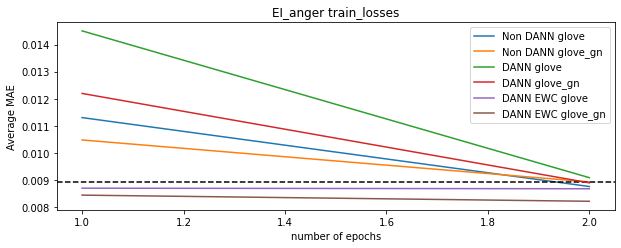

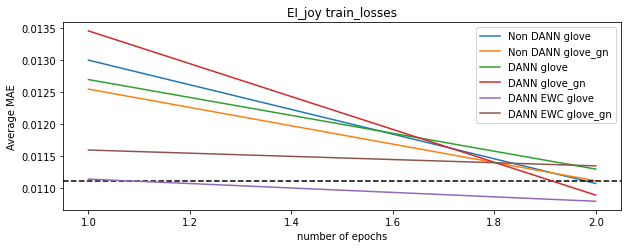

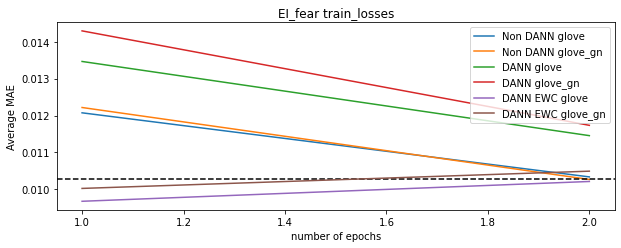

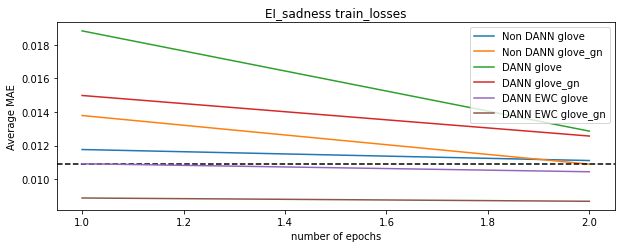

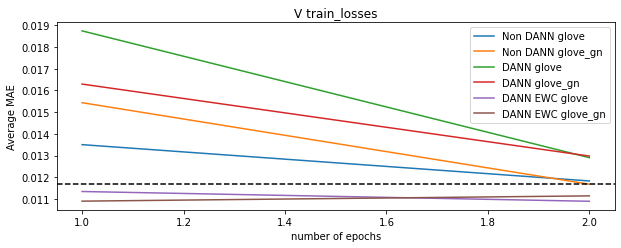

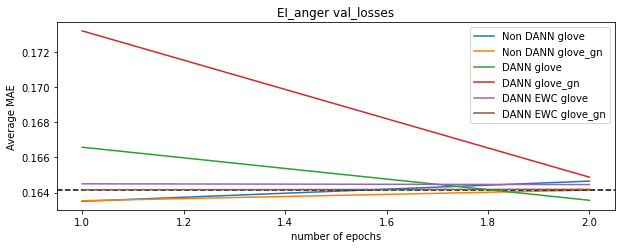

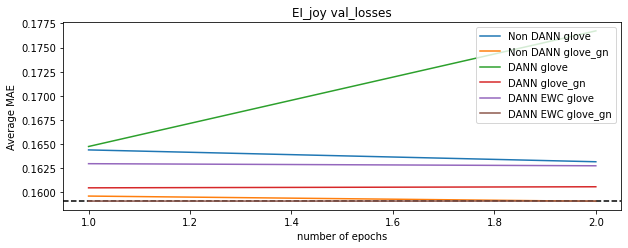

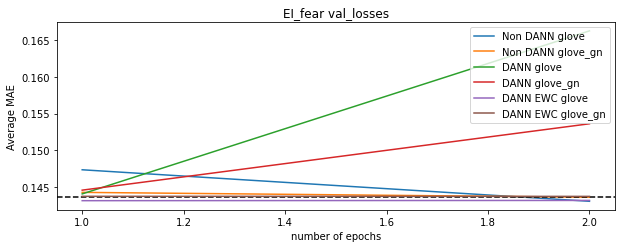

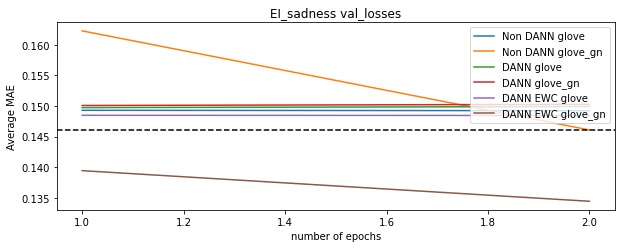

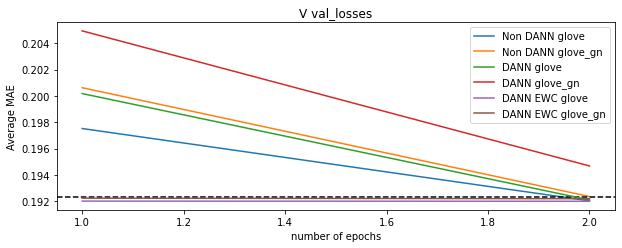

In [57]:
#@title Plotting Training and Validation Loss Function
plot_loss_curves(dict_file_name, dict_emb_file, dict_non_dann_losses_list, dict_dann_losses_list, dict_dann_ewc_losses_list, mode = "train_losses")
plot_loss_curves(dict_file_name, dict_emb_file, dict_non_dann_losses_list, dict_dann_losses_list, dict_dann_ewc_losses_list, mode = "val_losses")

In [118]:
#@title Printing Task Accuracy Results
# dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

# list_model_type = ['non_dann', 'dann', 'dann_ewc']
dict_model_losses_list = {'non_dann': dict_non_dann_losses_list, 
                          'dann' : dict_dann_losses_list, 
                          'dann_ewc' : dict_dann_ewc_losses_list
                          }
column_name = ['Task']
for model_type in dict_model_losses_list.keys():
  for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
    temp_column_name_1 = ("["+str(model_type)+"|"+str(embedding)+"]")
    temp_column_name_2 = "delta_"+ temp_column_name_1
    column_name.append(temp_column_name_1)
    column_name.append(temp_column_name_2)
# print (column_name)
df_task_results = pd.DataFrame(columns=column_name)


for name in dict_file_name.keys(): # ['EI_anger', 'EI_joy', 'EI_fear', 'EI_sadness', 'V']
  dict_task = {'Task': name}
  for model_type, dict_losses in dict_model_losses_list.items():
    for embedding in dict_emb_file.keys(): # 'glove', 'glove_gn'
      temp_column_name_1 = ("["+str(model_type)+"|"+str(embedding)+"]")
      temp_column_name_2 = "delta_"+ temp_column_name_1
      dict_temp = {temp_column_name_1 : float(dict_losses [name][embedding]['test_loss']),
                   temp_column_name_2 : 0.0 }
      dict_task = {**dict_task, **dict_temp}
  df_task_results = df_task_results.append(dict_task, ignore_index=True)
# print(df_task_results)


baseline = "[non_dann|glove]"
for index, row in df_task_results.iterrows():
  for col_name in df_task_results.columns:
    if "delta" not in col_name and col_name != 'Task' : 
      # print(index, baseline , float(row[baseline]), col_name,  float(row[col_name]) , round(100*(float(row[baseline]) - float(row[col_name]))/(float(row[baseline])),1)     )
      df_task_results.at[index,"delta_"+col_name] = round(100*(float(row[baseline]) - float(row[col_name]))/(float(row[baseline])),1) 


interesting_columns = []
for col_name in df_task_results.columns:
  if "delta" not in col_name and col_name != 'Task' : 
    interesting_columns.append(col_name)
df_temp = df_task_results[interesting_columns]
df_temp['Best_Model'] = df_temp.idxmin(axis=1) 
# print(df_temp)
df_task_results['Best_Model'] = df_temp['Best_Model'] 

df_task_results = df_task_results.drop('delta_[non_dann|glove]', axis =1)


dict_task_name_mapping = {'EI_fear' :'Fear Intensity Prediction',
                          'EI_anger' : 'Anger Intensity Prediction',
                          'V' : 'Valence Intensity Prediction',
                          'EI_sadness' : 'Sadness Intensity Prediction',
                          'EI_joy' : 'Joy Intensity Prediction'
                          }
df_task_results = df_task_results.replace({"Task":dict_task_name_mapping})
df_task_results


<ipython-input-118-6951fd0fc4d6>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Best_Model'] = df_temp.idxmin(axis=1)


,Task,[non_dann|glove],[non_dann|glove_gn],delta_[non_dann|glove_gn],[dann|glove],delta_[dann|glove],[dann|glove_gn],delta_[dann|glove_gn],[dann_ewc|glove],delta_[dann_ewc|glove],[dann_ewc|glove_gn],delta_[dann_ewc|glove_gn],Best_Model
0,Anger Intensity Prediction,0.157778,0.156946,0.5,0.155944,1.2,0.158069,-0.2,0.157474,0.2,0.157016,0.5,[dann|glove]
1,Joy Intensity Prediction,0.167064,0.158839,4.9,0.169233,-1.3,0.162182,2.9,0.166291,0.5,0.158891,4.9,[non_dann|glove_gn]
2,Fear Intensity Prediction,0.146065,0.146615,-0.4,0.170352,-16.6,0.156624,-7.2,0.146158,-0.1,0.146723,-0.5,[non_dann|glove]
3,Sadness Intensity Prediction,0.149722,0.145980,2.5,0.152658,-2.0,0.150044,-0.2,0.150112,-0.3,0.130985,12.5,[dann_ewc|glove_gn]
4,Valence Intensity Prediction,0.181278,0.184358,-1.7,0.181859,-0.3,0.191936,-5.9,0.181511,-0.1,0.183506,-1.2,[non_dann|glove]
